# Name: Omkar Thorve
# PRN: 24070149016

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.32MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.84MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training VAE...
Epoch 1/50, Loss: 290.8865
Epoch 2/50, Loss: 182.6434
Epoch 3/50, Loss: 164.6734
Epoch 4/50, Loss: 153.3008
Epoch 5/50, Loss: 145.6402
Epoch 6/50, Loss: 139.3480
Epoch 7/50, Loss: 134.1732
Epoch 8/50, Loss: 130.6671
Epoch 9/50, Loss: 128.3533
Epoch 10/50, Loss: 126.2298
Epoch 11/50, Loss: 124.3849
Epoch 12/50, Loss: 122.7351
Epoch 13/50, Loss: 121.2478
Epoch 14/50, Loss: 119.9125
Epoch 15/50, Loss: 118.7733
Epoch 16/50, Loss: 117.7249
Epoch 17/50, Loss: 116.7200
Epoch 18/50, Loss: 115.5168
Epoch 19/50, Loss: 114.8045
Epoch 20/50, Loss: 114.0384
Epoch 21/50, Loss: 113.5317
Epoch 22/50, Loss: 112.9403
Epoch 23/50, Loss: 112.4924
Epoch 24/50, Loss: 112.1916
Epoch 25/50, Loss: 111.6437
Epoch 26/50, Loss: 111.3839
Epoch 27/50, Loss: 110.9583
Epoch 28/50, Loss: 110.6599
Epoch 29/50, Loss: 110.2660
Epoch 30/50, Loss: 110.0958
Epoch 31/50, Loss: 109.8344
Epoch 32/50, Loss: 109.5951
Epoch 33/50, Loss: 109

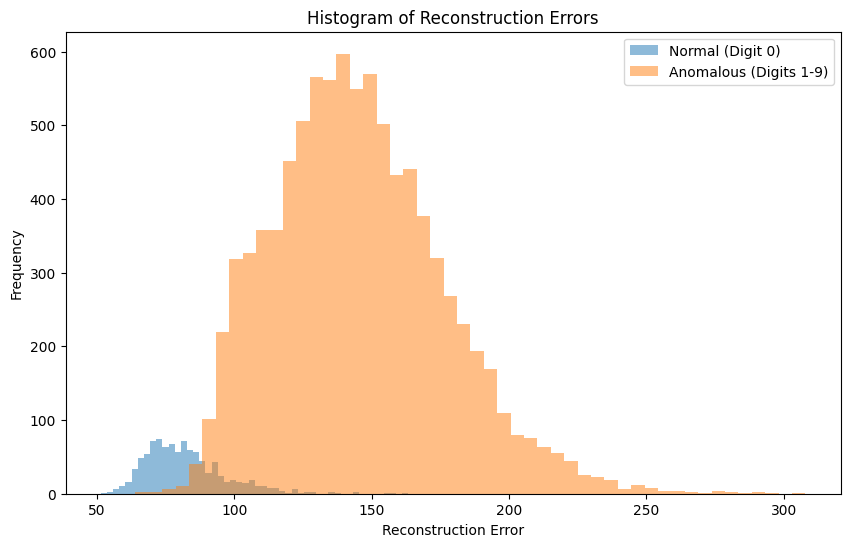

AUC-ROC: 0.9770


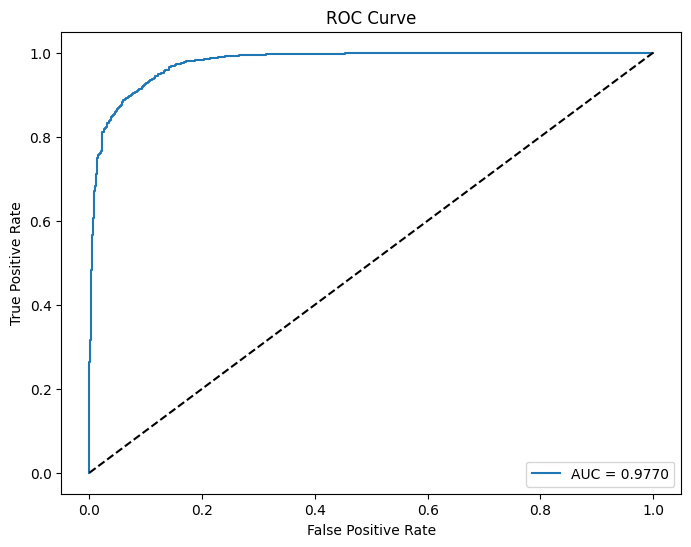

Visualizing reconstructions...


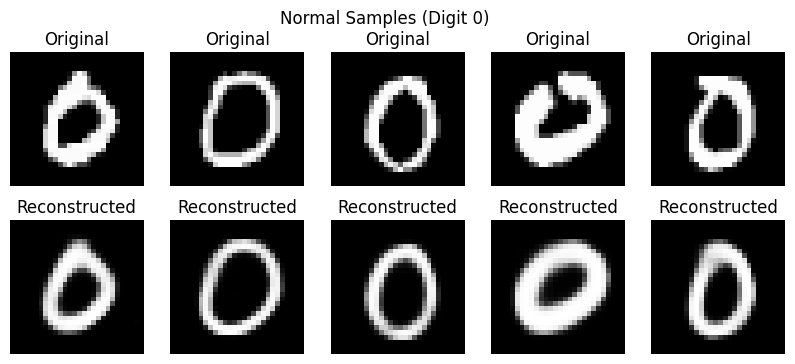

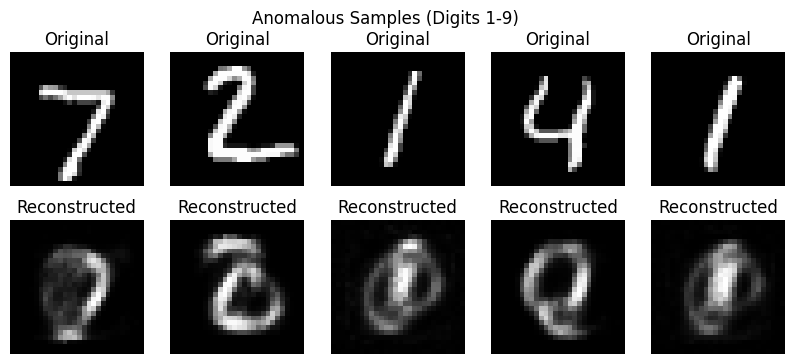

In [17]:
# --- Set Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Preprocess MNIST Dataset ---
transform = transforms.ToTensor()  # Converts images to tensors and scales to [0, 1]

# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter training set for digit '0' (normal class)
train_labels = train_dataset.targets
normal_indices = (train_labels == 0).nonzero().squeeze()
train_subset = Subset(train_dataset, normal_indices)

# Separate test set into normal (digit '0') and anomalous (digits '1'-'9')
test_labels = test_dataset.targets
normal_test_indices = (test_labels == 0).nonzero().squeeze()
anomalous_test_indices = (test_labels != 0).nonzero().squeeze()
normal_test_subset = Subset(test_dataset, normal_test_indices)
anomalous_test_subset = Subset(test_dataset, anomalous_test_indices)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
normal_test_loader = DataLoader(normal_test_subset, batch_size=batch_size, shuffle=False)
anomalous_test_loader = DataLoader(anomalous_test_subset, batch_size=batch_size, shuffle=False)

# --- Define the VAE Model ---
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # Input: 28x28 = 784
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, 20)      # Latent mean
        self.fc_logvar = nn.Linear(256, 20)  # Latent log variance
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def reconstruct(self, x):
        x = x.view(-1, 784)
        mu, _ = self.encode(x)
        recon_x = self.decode(mu)  # Used mean for deterministic reconstruction
        return recon_x

# ---  Loss Function ---
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Average over batch
    return (BCE + KLD) / x.size(0)

# --- Initialize Model and Optimizer ---
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Train the VAE ---
num_epochs = 50
print("Training VAE...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item() * data.size(0)
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# --- Compute Reconstruction Errors ---
def compute_reconstruction_errors(data_loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon_batch = model.reconstruct(data)
            bce = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='none')
            bce_per_sample = bce.sum(dim=1)  # Sum over pixels for each sample
            errors.extend(bce_per_sample.cpu().numpy())
    return errors

print("Computing reconstruction errors...")
normal_errors = compute_reconstruction_errors(normal_test_loader)
anomalous_errors = compute_reconstruction_errors(anomalous_test_loader)

# --- Plot Histograms of Reconstruction Errors ---
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal (Digit 0)')
plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous (Digits 1-9)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.show()

# --- Compute and Plot AUC-ROC ---
all_errors = normal_errors + anomalous_errors
labels = [0] * len(normal_errors) + [1] * len(anomalous_errors)
auc = roc_auc_score(labels, all_errors)
print(f"AUC-ROC: {auc:.4f}")

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(labels, all_errors)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Visualize Reconstructions ---
def visualize_reconstructions(data_loader, num_images=5, title=""):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        data = data.to(device)
        recon = model.reconstruct(data)
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i].cpu().squeeze(), cmap='gray')
            plt.title('Original')
            plt.axis('off')
            # Reconstructed
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

print("Visualizing reconstructions...")
visualize_reconstructions(normal_test_loader, title="Normal Samples (Digit 0)")
visualize_reconstructions(anomalous_test_loader, title="Anomalous Samples (Digits 1-9)")